# **Classification**  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/egokcen/TReND-CaMinA/blob/main/notebooks/Zambia25/17-Thu-Classification/classification.ipynb)

<img align="left" width="100" src="https://raw.githubusercontent.com/trendinafrica/TReND-CaMinA/main/images/CaMinA_logo.png">

### **TReND-CaMinA: Computational Neuroscience and Machine Learning Summer School, Zambia 2025**
#### **Content creator:** Evren Gokcen, Carnegie Mellon University

---

## **Overview**
In this lesson, we will learn about **classification** methods. Classification methods are used to predict discrete labels (or classes) from data. Classification is a fundamental task in machine learning and is widely used in neuroscience to decode brain activity patterns.

In this notebook, you will decode a monkey's intended arm reach angle from neurons recorded in motor area PMd.

<center><img src="https://github.com/egokcen/TReND-CaMinA/blob/main/notebooks/Zambia25/17-Thu-Classification/logistic_regression_animation1D.gif?raw=1" width=500><img src="https://github.com/egokcen/TReND-CaMinA/blob/main/notebooks/Zambia25/17-Thu-Classification/logistic_regression_animation2D.gif?raw=1" width=500></center>

## **Learning objectives / key questions**
1. Why is it possible to decode external variables (like movement direction, or visual stimulus identity) from neural activity?
2. What is binary classification? And what are two fundamental approaches to solving this problem?
3. What are decision boundaries and decision regions, and how are they used in classification?
4. What is the nearest neighbors method, and how do I implement it for one- and two-dimensional data?
5. What is logistic regression, and how do I implement it for one- and two-dimensional data?
6. How are nearest neighbors methods and logistic regression similar and different? And what are the strength and limitations of each method?

## **Contents**

**Core topics:**

0. [Import dependencies and data](#dependencies)
1. [Introduction: Decoding movement intention in the motor system](#introduction)
2. [Nearest neighbors classification](#nearest-neighbors)
3. [Logistic regression](#logistic-regression)

**Bonus topics:**

1. [Population decoding](#population-decoding)
2. [Combining classification and PCA](#class-pca)
3. [Multiclass classification](#multiclass)
4. [Further reading](#further-reading)

## 0. Import dependencis and data <a name="dependencies"></a>

In [ ]:
# If running in Colab, mount the drive folder
COLAB = False
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [1]:
!pip install numpy scipy matplotlib ipywidgets

%load_ext autoreload
%autoreload 2

import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import scipy.io as spio

from collections import Counter
from ipywidgets import interact
from matplotlib.animation import FuncAnimation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.1 MB/s eta 0:00:00


In [5]:
!wget https://raw.githubusercontent.com/kkipngenokoech/TReND-CaMinA-Zambia/main/notebooks/Zambia25/16-Wed-DimReduction/data_for_exercises.mat


--2025-07-17 07:38:48--  https://raw.githubusercontent.com/kkipngenokoech/TReND-CaMinA-Zambia/main/notebooks/Zambia25/16-Wed-DimReduction/data_for_exercises.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26708 (26K) [application/octet-stream]
Saving to: ‘data_for_exercises.mat’

data_for_exercises. 100%[===================>]  26.08K  --.-KB/s    in 0.01s   

2025-07-17 07:38:49 (2.51 MB/s) - ‘data_for_exercises.mat’ saved [26708/26708]



## Introduction: Decoding movement intention in the motor system <a name="introduction"></a>

Let's start where we left off yesterday, with dimensionality reduction.
Recall yesterday's data $^1$ (`data_for_exercises.mat`, on the Google Drive), which
contains the following variable:
- `Xplan`: a 2D array of shape `(n, d)`. Here we have `n = 728` trials and `d = 97`
neurons recorded simultaneously in area PMd. `Xplan[i, j]` is the spike count of neuron
`j` on trial `i`, taken within a 200 ms bin while the monkey is planning an arm reach.
There are 91 trials for each of 8 reaching angles. Trials are ordered by angle, so the
first 91 trials are for angle 0, the next 91 trials are for angle 45, and so on.

1. The neural data have been generously provided by the laboratory of Prof. Krishna
Shenoy at Stanford University. The data are to be used exclusively for educational
purposes in this course.


### Revisiting PCA <a name=""></a>

#### Load the data

In [6]:
# Set paths to data file
datapath  = '' # add your path here
datafile  = '/content/data_for_exercises.mat'

# Load the Matlab format .mat data into Python
mat = spio.loadmat(datapath + datafile, squeeze_me=True)
Xplan = mat['Xplan']
# Convert the data from uint8 to float64
Xplan = Xplan.astype(np.float64)

# Check the shape of the data
n, d = Xplan.shape
print('Xplan dimensions: (n trials, d neurons)')
print((n, d))

# Other basic constants
num_reaches_per_angle = 91
num_angles = 8
angles = [30.0, 70.0, 110.0, 150.0, 190.0, 230.0, 310.0, 350.0]  # In degrees

Xplan dimensions: (n trials, d neurons)
(728, 97)


#### Compute the sample covariance and diagonalize it (PCA)

Recall that the sample covariance matrix
$S = \frac{1}{n} \sum_i (\boldsymbol{x}_i-\boldsymbol{\mu})(\boldsymbol{x}_i-\boldsymbol{\mu})^{\intercal}$,
and the sample mean $\boldsymbol{\mu} = \frac{1}{n} \sum_i \boldsymbol{x}_i$.

In [7]:
# First find the mean over trials (axis=0) of each neuron
mu = np.mean(Xplan, axis=0)

# Now compute the data covariance
Xplan_centered = Xplan - mu  # Don't forget to center your data first!
cov = (1/n) * Xplan_centered.T @ Xplan_centered  # Now you can compute the covariance

# Perform eigendecomposition of the data covariance
D, U = np.linalg.eig(cov)  # D = vector of eigenvalues, U = matrix of eigenvectors

# Make sure the eigenvalues are sorted (in descending order)
idx = np.argsort(D)[::-1]
D = D[idx]

# Arrange the eigenvectors according to the magnitude of the eigenvalues
U = U[:, idx]

#### Project the data onto the top 3 principal components and visualize

Recall that projections of the data points $\boldsymbol{x}_i \in \mathbb{R}^d$ into the
three-dimensional PC space are given by the PC scores, $\boldsymbol{z}_i \in \mathbb{R}^3$, where $z_k^i = \boldsymbol{u}_k^{\intercal} (\boldsymbol{x}_i - \boldsymbol{\mu})$, $k=1,2,3$.

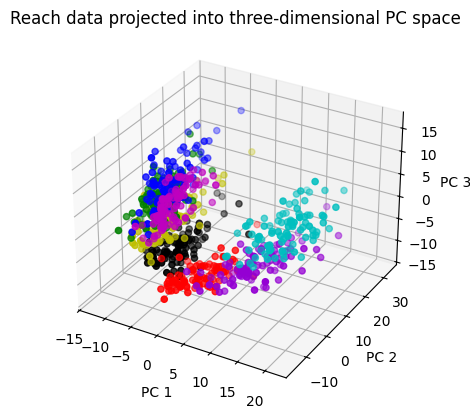

In [8]:
colors = ['r', 'k', 'y', 'g', 'b', 'm', 'c', 'darkviolet']

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for reach_idx in range(num_angles):
  # Get the trials corresponding to the current reach angle
  trial_idxs = np.arange(0,num_reaches_per_angle,1) + (reach_idx)*num_reaches_per_angle
  X = Xplan_centered[trial_idxs,:]
  ax.scatter(X @ U[:, 0], X @ U[:, 1], X @ U[:, 2], '.', color=colors[reach_idx])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

plt.title('Reach data projected into three-dimensional PC space');

**_💬 Discussion questions:_**

1. What is striking about these projections?
2. What property of PMd neurons might lead to this pattern?

### Tuning curves

Let's take a step back from PCA and compute tuning curves for each neuron.
Recall that the tuning curve of a neuron is the average firing rate of the neuron (over
trials) as a function of the reach angle.

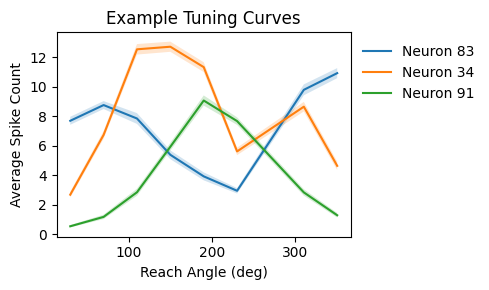

In [9]:
# It's helpful here to reshape the data into a 3D array, with an extra axis for the
# reach angle
Xplan_angles = Xplan.reshape((num_angles, num_reaches_per_angle, d))

# Now we can compute the average firing rate for each neuron at each reach angle
tuning_curves = np.mean(Xplan_angles, axis=1)
# Compute also the standard error of the mean (SEM) for each neuron at each reach angle
sem_tuning_curves = np.std(Xplan_angles, axis=1) / np.sqrt(num_reaches_per_angle)

# let's pick a few neurons that might be particularly well tuned
num_examples = 3
mean_firing_rates = np.mean(tuning_curves, axis=0)
# Here we'll choose neurons based on their contribution to one of the PCs
top_neurons = np.argsort(np.abs(U[:, 2]))[-num_examples:]

fig, ax = plt.subplots(figsize=(5, 3))
for i in range(num_examples):
    # Plot error bands for the SEM
    ax.fill_between(
        angles,
        tuning_curves[:, top_neurons[i]] - sem_tuning_curves[:, top_neurons[i]],
        tuning_curves[:, top_neurons[i]] + sem_tuning_curves[:, top_neurons[i]],
        alpha=0.2,
    )
    # Plot the tuning curve
    ax.plot(
        angles,
        tuning_curves[:, top_neurons[i]],
        label=f'Neuron {top_neurons[i]}',
    )
ax.set_xlabel('Reach Angle (deg)')
ax.set_ylabel('Average Spike Count')
ax.set_title('Example Tuning Curves')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()

**_💬 Discussion questions:_**

- What is the shape of the tuning curves? How does that relate to the nature of reach angles?

## Nearest neighbors classification <a name="nearest-neighbors"></a>

Given how nicely the neural responses appear to be organized according to reach angle,
both based on PCA and tuning curves, perhaps we can use this information to
decode, or classify, the reach angle from the neural responses.

We'll start our journey with the Nearest Neighbors classifier.

### Binary classification with one neuron

To warm up, let's simplify the problem first:
1. Let's consider only two reach angles. We are thus interested in
   *binary classification*.
2. Let's consider only one neuron's response, and see how far we can get in decoding.

In [ ]:
neuron_idx = 91  # The neuron we'll use for binary classification
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, neuron_idx]
X_reach2 = Xplan_angles[reach_idx2, :, neuron_idx]

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])  # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]

# Visualize the responses on each trial
plt.figure(figsize=(8, 4))
# Spike counts are integer values, and so many data points will overlap.
# Let's add an offset and a small amount of jitter to the y-axis, purely for
# visualization purposes.
plt.plot(
    X_train_reach1,
    -0.1 + np.random.normal(0, 0.02, size=y_train_reach1.shape),
    'r.',
    label=f'{angles[reach_idx1]}° reach',
)
plt.plot(
    X_train_reach2,
    0.1 + np.random.normal(0, 0.02, size=y_train_reach2.shape),
    'b.',
    label=f'{angles[reach_idx2]}° reach',
)
plt.ylim(-0.5, 0.5)
plt.xlabel('Spike Count')
# Remove the y-ticks since they are not informative in this case
plt.yticks([])
plt.title(f'Responses for Two Reach Angles, Neuron {neuron_idx}')
plt.legend()
plt.show()

It looks like these neural responses have decent separation by the two angles!

What if we bring in a few test points?

In [ ]:
reach1_tests = [0, 8]  # Test trial indices
reach2_tests = [0, 1]

# Replot the training data
plt.figure(figsize=(8, 4))
# Spike counts are integer values, and so many data points will overlap.
# Let's add an offset and a small amount of jitter to the y-axis, purely for
# visualization purposes.
plt.plot(
    X_train_reach1,
    -0.1 + np.random.normal(0, 0.02, size=y_train_reach1.shape),
    'r.',
    label=f'{angles[reach_idx1]}° reach',
)
plt.plot(
    X_train_reach2,
    0.1 + np.random.normal(0, 0.02, size=y_train_reach2.shape),
    'b.',
    label=f'{angles[reach_idx2]}° reach',
)
# And plot the test points
for test_trial_idx in reach1_tests:
    plt.plot(X_test_reach1[test_trial_idx], 0.2, '*', markersize=12)
for test_trial_idx in reach2_tests:
    plt.plot(X_test_reach2[test_trial_idx], 0.2, '*', markersize=12)
plt.ylim(-0.5, 0.5)
plt.xlabel('Spike Count')
# Remove the y-ticks since they are not informative in this case
plt.yticks([])
plt.title(f'Responses for Two Reach Angles, Neuron {neuron_idx}')
plt.legend()
plt.show()

**_💬 Discussion questions:_**

- How would you classify each of these test points? Why?

#### Nearest neighbors classification: A simple majority vote

We can formalize some of the intuitive principles you likely used above to get the
Nearest Neighbors classifier. In essence, the Nearest Neighbors classifier works
as follows: given a test data point, find the *k* training data points that are closest
to it, and those neighbors "choose" the class label of the test point by majority vote.

We'll then need three key components to implement this:

1. **Distance Metric**: We need a way to measure the distance or similarity between data
   points.
2. **k-Nearest Neighbors**: For a given test instance, we need to identify the k
   training data points that are closest to it.
3. **Majority Vote**: We need to identify the most common class label among the k
   nearest neighbors and assign that label to the test instance.

**_📝 Exercise_**

Let's start by creating a base KNN class. Wherever you see a `TODO` (there are **three**), attempt to fill in that line of code.

You can find the solution below.

In [ ]:
class KNNBase:
    def __init__(self, k: int = 3):
        """
        Initialize the KNN classifier with one hyperparameter: k.

        Parameters
        ----------
        k : int
            The number of nearest neighbors to consider for classification. Default: 3.
        """
        self.k = k

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the model to the training data.

        For the KNN classifier, "fitting" simply stores the training data and labels.

        Parameters
        ----------
        X : numpy array, shape (n, d)
            The training data, with n samples and d features.
        y : numpy array, shape (n,)
            The labels corresponding to the training data.
        """
        self.X_train = []  # TODO
        self.y_train = []  # TODO

    def distance(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """
        Compute the distance between two points.

        Parameters
        ----------
        x1 : numpy array
            The first point.
        x2 : numpy array
            The second point.

        Returns
        -------
        float
            The distance between the two points.
        """
        # We'll implement this later
        pass

    def predict(self, x: np.ndarray) -> int:
        """
        Predict the labels for a single input data point.

        Parameters
        ----------
        x : numpy array, shape (d,)
            A single input data point for which to predict the label.

        Returns
        -------
        y_pred : int
            The predicted label for the input data point.
        """
        # Compute the distances from the input point to all training points
        distances = [self.distance(x, x_train) for x_train in self.X_train]

        # Get the closest k neighbors
        k_indices = []  # TODO - Hint: Use the np.argsort function
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Majority vote
        most_common = Counter(k_nearest_labels).most_common()
        return most_common[0][0]

    def predict_batch(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the labels for a batch of input data points.

        Parameters
        ----------
        X : numpy array, shape (n, d)
            The input data for which to predict labels.

        Returns
        -------
        y_pred : numpy array, shape (n,)
            The predicted labels for the input data batch.
        """
        return np.array([self.predict(x) for x in X])

In [ ]:
#@title Double click to see solution {display-mode: "form" }
class KNNBase:
    def __init__(self, k: int = 3):
        """
        Initialize the KNN classifier with one hyperparameter: k.

        Parameters
        ----------
        k : int
            The number of nearest neighbors to consider for classification. Default: 3.
        """
        self.k = k

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the model to the training data.

        For the KNN classifier, "fitting" simply stores the training data and labels.

        Parameters
        ----------
        X : numpy array, shape (n, d)
            The training data, with n samples and d features.
        y : numpy array, shape (n,)
            The labels corresponding to the training data.
        """
        self.X_train = X  # SOLUTION
        self.y_train = y  # SOLUTION

    def distance(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """
        Compute the distance between two points.

        Parameters
        ----------
        x1 : numpy array
            The first point.
        x2 : numpy array
            The second point.

        Returns
        -------
        float
            The distance between the two points.
        """
        pass

    def predict(self, x: np.ndarray) -> int:
        """
        Predict the labels for a single input data point.

        Parameters
        ----------
        x : numpy array, shape (d,)
            A single input data point for which to predict the label.

        Returns
        -------
        y_pred : int
            The predicted label for the input data point.
        """
        # Compute the distances from the input point to all training points
        distances = [self.distance(x, x_train) for x_train in self.X_train]

        # Get the closest k neighbors
        k_indices = np.argsort(distances)[:self.k]  # SOLUTION
        k_nearest_labels = [self.y_train[i] for i in k_indices]

        # Majority vote
        most_common = Counter(k_nearest_labels).most_common()
        return most_common[0][0]

    def predict_batch(self, X: np.ndarray) -> np.ndarray:
        """
        Predict the labels for a batch of input data points.

        Parameters
        ----------
        X : numpy array, shape (n, d)
            The input data for which to predict labels.

        Returns
        -------
        y_pred : numpy array, shape (n,)
            The predicted labels for the input data batch.
        """
        return np.array([self.predict(x) for x in X])

#### Distance Metric

We now have everything in place except for our distance metric. In our 1D
(single-neuron) case, we can simply use the absolute difference between the spike counts
of the neuron for the test point and the training points.

**_📝 Exercise_**

Implement the distance function below.

Wherever you see a `TODO` (there is **one**), attempt to fill in that line of code.

You can find the solution below.

In [ ]:
def abs_distance(x1: np.ndarray, x2: np.ndarray) -> float:
    """
    Compute the absolute distance between two 1D data points.

    Parameters
    ----------
    x1 : numpy array
        The first data point.
    x2 : numpy array
        The second data point.

    Returns
    -------
    float
        The absolute distance between the two points.
    """
    return None  # TODO: Replace None with your solution (use numpy functions)

In [ ]:
#@title Double click to see solution {display-mode: "form" }
def abs_distance(x1: np.ndarray, x2: np.ndarray) -> float:
    """
    Compute the absolute distance between two 1D data points.

    Parameters
    ----------
    x1 : numpy array
        The first data point.
    x2 : numpy array
        The second data point.

    Returns
    -------
    float
        The absolute distance between the two points.
    """
    return np.abs(x1 - x2)  # SOLUTION

Let's now use this distance metric to implement our first KNN classifier!

Instantiate the class:

In [ ]:
# To instantiate the class, all we need to provide is the number of neighbors k.
knn_1D = KNNBase(k=5)
# Then we can add the distance metric we just defined.
knn_1D.distance = abs_distance

**_📝 Exercise_**

"Train" the model!

Wherever you see a `TODO` (there is **one**), attempt to fill in that line of code.

You can find the solution below.

In [ ]:
# Prep the data for compatibility with our KNN class
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Fit the KNN model
# TODO

In [ ]:
#@title Double click to see solution {display-mode: "form" }
# Prep the data for compatibility with our KNN class
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Fit the KNN model
knn_1D.fit(X_train, y_train)  # SOLUTION

Having trained the model, we can now use it to make predictions on new data.
And importantly, we'll need to be able to evaluate how well the model performs on these
new unseen data points.

**_📝 Exercise_**

Implement the function to compute classification accuracy.

Wherever you see a `TODO` (there is **one**), attempt to fill in that line of code.

You can find the solution below.

In [ ]:
# Let's define a function to compute the accuracy of our KNN model
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute the classification accuracy of the model.

    Parameters
    ----------
    y_true : numpy array, shape (n,)
        The true labels for the data points.
    y_pred : numpy array, shape (n,)
        The predicted labels for the data points.

    Returns
    -------
    float
        The classification accuracy, defined as the proportion of correct predictions.
    """
    return None  # TODO: Replace None with your solution (use numpy functions)

In [ ]:
#@title Double click to see solution {display-mode: "form" }
# Let's define a function to compute the accuracy of our KNN model
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Compute the classification accuracy of the model.

    Parameters
    ----------
    y_true : numpy array, shape (n,)
        The true labels for the data points.
    y_pred : numpy array, shape (n,)
        The predicted labels for the data points.

    Returns
    -------
    float
        The classification accuracy, defined as the proportion of correct predictions.
    """
    return np.mean(y_true == y_pred)  # SOLUTION

Predict labels for the test data and evaluate our model's accuracy:

In [ ]:
# Prep the data for compatibility with our KNN class
# Train
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

# Predict the labels for the train data
y_pred_train = knn_1D.predict_batch(X_train)

# Predict the labels for the test data
y_pred_test = knn_1D.predict_batch(X_test)

# Train accuracy
acc_train = accuracy(y_train, y_pred_train)
print(f'Train accuracy: {acc_train:.3f}')

# Test accuracy
acc_test = accuracy(y_test, y_pred_test)
print(f'Test accuracy: {acc_test:.3f}')

That's quite good! Let's visualize the test points from before, and color them by
their predicted class labels. Do these predictions make sense?

In [ ]:
reach1_tests = [0, 8]  # Test trial indices
reach2_tests = [0, 1]

# Reshape the predicted test labels to include an additional axis for reach angle
y_pred_reaches = y_pred_test.reshape(2, -1).T
y_pred_reach1 = y_pred_reaches[:, 0]
y_pred_reach2 = y_pred_reaches[:, 1]

# Replot the training data
plt.figure(figsize=(8, 4))
# Spike counts are integer values, and so many data points will overlap.
# Let's add an offset and a small amount of jitter to the y-axis, purely for
# visualization purposes.
plt.plot(
    X_train_reach1,
    -0.1 + np.random.normal(0, 0.02, size=y_train_reach1.shape),
    'r.',
    label=f'{angles[reach_idx1]}° reach',
)
plt.plot(
    X_train_reach2,
    0.1 + np.random.normal(0, 0.02, size=y_train_reach2.shape),
    'b.',
    label=f'{angles[reach_idx2]}° reach',
)
# And plot the test points with their predicted labels
for test_trial_idx in reach1_tests:
    color = 'r' if y_pred_reach1[test_trial_idx] == 0 else 'b'
    plt.plot(X_test_reach1[test_trial_idx], 0.2, '*', markersize=12, color=color)
for test_trial_idx in reach2_tests:
    color = 'r' if y_pred_reach2[test_trial_idx] == 0 else 'b'
    plt.plot(X_test_reach2[test_trial_idx], 0.2, '*', markersize=12, color=color)
plt.ylim(-0.5, 0.5)
plt.xlabel('Spike Count')
# Remove the y-ticks since they are not informative in this case
plt.yticks([])
plt.title(f'Responses for Two Reach Angles, Neuron {neuron_idx}')
plt.legend()
plt.show()

**_💬 Discussion questions:_**

- Based on the predicted labels shown above, is there a simple rule that
   would allow us to classify the test points correctly, without using the KNN
   classifier?

#### Decision boundaries, part 1

It seems like there might be a critical threshold spike count: Below this threshold,
the model predicts one angle, and above it, the other angle.

This introduces the concept of a *decision boundary*. Let's visualize our KNN
classifier's *decision regions*, and the corresponding decision boundary that results
from them.

In [ ]:
# Let's now visualize the decision boundaries of our KNN model
# We'll create a grid of points along the x-axis and predict their labels
x_min, x_max = X_train.min() - 1, X_train.max() + 1
xx = np.linspace(x_min, x_max, 100)
y_grid_pred = knn_1D.predict_batch(xx)

# Now visualize the predicted labels of the grid points, along with the training data
plt.figure(figsize=(8, 4))
# Plot the predicted labels of the grid points
plt.scatter(xx, np.zeros_like(xx), c=y_grid_pred, cmap='coolwarm_r', alpha=0.3, s=10)
# Plot the training data, with a small amount of jitter for visualization
plt.plot(
    X_train_reach1,
    -0.1 + np.random.normal(0, 0.02, size=y_train_reach1.shape),
    'r.',
    label=f'{angles[reach_idx1]}° reach',
)
plt.plot(
    X_train_reach2,
    0.1 + np.random.normal(0, 0.02, size=y_train_reach2.shape),
    'b.',
    label=f'{angles[reach_idx2]}° reach',
)
plt.ylim(-0.5, 0.5)
plt.xlabel('Spike Count')
# Remove the y-ticks since they are not informative in this case
plt.yticks([])
plt.title('Decision Boundaries of the 1D KNN Model')
plt.legend()
plt.show()

**_💬 Discussion questions:_**

- Does this decision boundary align with our test predictions, above?

### Binary classification with two neurons

We're now ready to extend our Nearest Neighbors classifier to two neurons!

In [ ]:
# Let's start by visualizing the training data for two neurons
neuron_idxs = [91, 34]  # The neurons we'll use for binary classification
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, neuron_idxs].T
X_reach2 = Xplan_angles[reach_idx2, :, neuron_idxs].T

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])  # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(1)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]

# Visualize the responses on each trial
plt.figure(figsize=(6, 5))
# Spike counts are integer values, and so many data points will overlap.
# Let's add an offset and a small amount of jitter to the y-axis, purely for
# visualization purposes.
plt.plot(
    X_train_reach1[:, 0] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
    X_train_reach1[:, 1] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
    'r.',
    label=f'{angles[reach_idx1]}° reach',
)
plt.plot(
    X_train_reach2[:, 0] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
    X_train_reach2[:, 1] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
    'b.',
    label=f'{angles[reach_idx2]}° reach',
)
plt.xlabel(f'Spike Count, Neuron {neuron_idxs[0]}')
plt.ylabel(f'Spike Count, Neuron {neuron_idxs[1]}')
plt.title(f'Responses for Two Reach Angles, Neurons {neuron_idxs}')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()

This looks highly separable! How should we modify our KNN class to handle two neurons?

**_📝 Exercise_**

Implement the function to compute Euclidean distance between two points.

Wherever you see a `TODO` (there is **one**), attempt to fill in that line of code.

You can find the solution below.

In [ ]:
def euclidean_distance(x1: np.ndarray, x2: np.ndarray) -> float:
    """
    Compute the Euclidean distance between two data points.

    Parameters
    ----------
    x1 : numpy array
        The first data point.
    x2 : numpy array
        The second data point.

    Returns
    -------
    float
        The Euclidean distance between the two points.
    """
    return None  # TODO: Replace None with your solution (use numpy functions)

In [ ]:
#@title Double click to see solution {display-mode: "form" }
def euclidean_distance(x1: np.ndarray, x2: np.ndarray) -> float:
    """
    Compute the Euclidean distance between two data points.

    Parameters
    ----------
    x1 : numpy array
        The first data point.
    x2 : numpy array
        The second data point.

    Returns
    -------
    float
        The Euclidean distance between the two points.
    """
    return np.sqrt(np.sum((x1 - x2) ** 2))  # SOLUTION

We can now take the same steps as before to create and train our KNN classifier.

Instantiate the class:

In [ ]:
knn_2D = KNNBase(k=5)
knn_2D.distance = euclidean_distance

"Train" the model:

In [ ]:
# Prep the data for compatibility with our KNN class
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Fit the KNN model
knn_2D.fit(X_train, y_train)

Predict labels for the test data and evaluate our model's accuracy:

In [ ]:
# Prep the data for compatibility with our KNN class
# Train
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

# Predict the labels for the train data
y_pred_train = knn_2D.predict_batch(X_train)

# Predict the labels for the test data
y_pred_test = knn_2D.predict_batch(X_test)

# Train accuracy
acc_train = accuracy(y_train, y_pred_train)
print(f'Train accuracy: {acc_train:.3f}')

# Test accuracy
acc_test = accuracy(y_test, y_pred_test)
print(f'Test accuracy: {acc_test:.3f}')

That's again quite good!

#### Decision boundaries, part 2

Let's revisit the idea of decision boundaries, but now for our two-dimensional data.

**_💬 Discussion questions:_**
- How would you draw the decision boundary for our two-neuron KNN
classifier?

Then let's go ahead and visualize the true decision boundary for our classifier.

In [ ]:
# Let's now visualize the decision boundaries of our KNN model
# We'll create a 2D grid of points and predict their labels
x_min, x_max = np.min(X_train[:, 0]) - 1, np.max(X_train[:, 0]) + 1
y_min, y_max = np.min(X_train[:, 1]) - 1, np.max(X_train[:, 1]) + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
grid_points = np.c_[xx.ravel(), yy.ravel()]
y_grid_pred = knn_2D.predict_batch(grid_points)

# Now visualize the predicted labels of the grid points, along with the training data
plt.figure(figsize=(6, 5))
# Plot the decision boundary
plt.scatter(
    grid_points[:, 0],
    grid_points[:, 1],
    c=y_grid_pred,
    cmap='coolwarm_r',
    alpha=0.3,
    s=5,
)
# Plot the training data, with a small amount of jitter for visualization
plt.plot(
    X_train_reach1[:, 0] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
    X_train_reach1[:, 1] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
    'r.',
    label=f'{angles[reach_idx1]}° reach',
)
plt.plot(
    X_train_reach2[:, 0] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
    X_train_reach2[:, 1] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
    'b.',
    label=f'{angles[reach_idx2]}° reach',
)
plt.xlabel(f'Spike Count, Neuron {neuron_idxs[0]}')
plt.ylabel(f'Spike Count, Neuron {neuron_idxs[1]}')
plt.title('Decision Boundaries of the 2D KNN Model')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()

**_📝 Exercises_**

1. Rerun the above analyses, but try different values for $k$. What happens to the decision boundary as $k$ changes? How does $k$ control the effective complexity of the classifier?
2. Rerun the above analyses, but try different pairs of reach angles to classify. Which pairs result in the best classification performance, and why? Which pairs result in the the worst classification performance, and why?

## Logistic Regression: Parametrizing the decision boundary directly <a name="logistic-regression"></a>

You may have noticed that, for certain values of $k$, the decision boundary looks
essentially like a straight line. Perhaps we can do well, then, by directly choosing
the decision boundary to be linear, and then estimating the best slope and intercept
of that line from the data. This brings us to logistic regression.

### One-dimensional decision boundaries: A simple threshold value

Let's return to the one-dimensional, single-neuron case. Again, we want to classify two reach angles, using the spike counts from one neuron.

This time, let's set a threshold value, $b$ directly, with the following rule:
$$\text{If } x < b, \text{ then predict angle 1. Else, predict angle 2.}$$

Note: This threshold value $b$ is frequently referred to as the *bias* term in machine learning.

In [ ]:
#@title Let's prepare the 1D data as before {display-mode: "form" }
neuron_idx = 91  # The neuron we'll use for binary classification
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, neuron_idx]
X_reach2 = Xplan_angles[reach_idx2, :, neuron_idx]

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])  # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

Then let's play around with a threshold ourselves, and see how it affects the decision boundary and the classification performance.

In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(b=widgets.FloatSlider(min=0, max=12, step=0.5, value=2))
def plot_decision_boundary(b):
    plt.figure(figsize=(6, 5))
    # Replot the training data
    # Spike counts are integer values, and so many data points will overlap.
    # Let's add an offset and a small amount of jitter to the y-axis, purely for
    # visualization purposes.
    # Seed the random number generator for reproducibility
    np.random.seed(0)
    plt.plot(
        X_train_reach1,
        -0.1 + np.random.normal(0, 0.02, size=y_train_reach1.shape),
        'r.',
        label=f'{angles[reach_idx1]}° reach',
    )
    plt.plot(
        X_train_reach2,
        0.1 + np.random.normal(0, 0.02, size=y_train_reach2.shape),
        'b.',
        label=f'{angles[reach_idx2]}° reach',
    )
    # Plot the decision boundary
    plt.axvline(x=b, color='m', linestyle='--', label=f'Threshold b={b:.1f}')

    # Let's also compute classification accuracy for the current threshold

    # Predict the labels for the train data
    y_pred_train = (X_train > b).astype(int)

    # Predict the labels for the test data
    y_pred_test = (X_test > b).astype(int)

    # Train accuracy
    acc_train = accuracy(y_train, y_pred_train)

    # Test accuracy
    acc_test = accuracy(y_test, y_pred_test)

    # Final plot formatting
    plt.ylim(-0.5, 0.5)
    plt.xlabel('Spike Count')
    # Remove the y-ticks since they are not informative in this case
    plt.yticks([])
    plt.title(f"Decision Threshold b={b:.1f}; Train acc: {acc_train:.3f}, Test acc: {acc_test:.3f}")
    plt.show()

**_💬 Discussion questions:_**

1. At which values of $b$ does this classifier perform as well as the KNN classifier (with $k = 5$)?
2. Are there values of $b$ where this classifier performs even better than the KNN classifier?

#### **Note:** Parametric vs non-parametric classifiers

This simple threshold classifier is our first example of a *parametric classifier*.
The parameter, in this case, is the threshold value $b$.

### Two-dimensional decision boundaries: A line with a slope and intercept

Let's now extend this idea to two dimensions. We can represent the decision boundary as a line with a slope and intercept:
$$y = wx + b$$

where $w$ is the slope and $b$ is the intercep, or bias. And from this line, we can define
the decision rule as follows:
$$\text{If } y < wx + b, \text{ then predict angle 1. Else, predict angle 2.}$$

In [ ]:
#@title Let's prepare the 2D data as before {display-mode: "form" }

neuron_idxs = [91, 34]  # The neurons we'll use for binary classification
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, neuron_idxs].T
X_reach2 = Xplan_angles[reach_idx2, :, neuron_idxs].T

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])  # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

Then we can now play around with the slope $w$ and the intercept $b$, and see how they affect the decision boundary and the classification performance.

In [ ]:
# Let's play around with both the slope, w, and the intercept, b, of the decision boundary
@interact(w=widgets.FloatSlider(min=-2, max=2, step=0.1, value=-0.2),
          b=widgets.FloatSlider(min=0, max=15, step=0.5, value=5))
def plot_decision_boundary(w, b):
    plt.figure(figsize=(8, 5))
    # Replot the training data
    # Spike counts are integer values, and so many data points will overlap.
    # Let's add an offset and a small amount of jitter to the y-axis, purely for
    # visualization purposes.
    # Seed the random number generator for reproducibility
    np.random.seed(0)
    plt.plot(
        X_train_reach1[:, 0] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
        X_train_reach1[:, 1] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
        'r.',
        label=f'{angles[reach_idx1]}° reach',
    )
    plt.plot(
        X_train_reach2[:, 0] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
        X_train_reach2[:, 1] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
        'b.',
        label=f'{angles[reach_idx2]}° reach',
    )
    # Plot the decision boundary
    x_vals = np.linspace(X_train[:, 0].min(), X_train[:, 0].max()-3, 100)
    y_vals = w * x_vals + b
    plt.plot(x_vals, y_vals, 'm--', label='Decision Boundary')

    # Let's also compute classification accuracy for the current slope and intercept

    # Predict the labels for the train data
    y_pred_train = (X_train @ np.array([w, -1]) + b < 0).astype(int)

    # Predict the labels for the test data
    y_pred_test = (X_test @ np.array([w, -1]) + b < 0).astype(int)

    # Train accuracy
    acc_train = accuracy(y_train, y_pred_train)

    # Test accuracy
    acc_test = accuracy(y_test, y_pred_test)

    # Final plot formatting
    plt.xlabel(f'Spike Count, Neuron {neuron_idxs[0]}')
    plt.ylabel(f'Spike Count, Neuron {neuron_idxs[1]}')
    plt.title(f"Decision Boundary: y={w:.2f}x + {b:.1f}; Train acc: {acc_train:.3f}, Test acc: {acc_test:.3f}")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    plt.tight_layout()
    plt.show()

**_💬 Discussion questions:_**

1. How many parameters does our classifier now have?
2. At which values of the slope, $w$, and the intercept, $b$, does this classifier perform as well as the KNN classifier (with $k = 5$)?
3. Are there values of $w$ and $b$ where this classifier performs even better than the KNN classifier?

### Toward logistic regression

Our approach so far has been to manually set the slope and intercept of the decision boundary, and then to classify data points in a binary manner based on whether they fall above or below this line.

**_💬 Discussion questions:_**

What are the drawbacks of this approach? Consider the following prompts:

1. Should points very close to the decision boundary be treated the same as points far away from it?
2. What if the data are more complex? Especially, if the data are not clearly separable, and if we start considering more than two neurons?

#### Probabilities and the logistic sigmoid function

To address the first limitation, we'll start working with probabilities.
Specifically, we want to be able to answer the following question:

*Given a data point, what is the probability that it belongs to class (reach angle) 1?*

In math terms, we would write this statement as:
$$P(C_1 | \mathbf{x})$$

Review question: What key properties define a probability?
- A probability is a value between 0 and 1.
- The sum of probabilities for all possible classes must equal 1.

#### The logistic sigmoid function

This brings us to the logistic sigmoid function, which is defined as:
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

**_📝 Exercise_**

To gain intuition, let's implement the logistic sigmoid in code.

Wherever you see a `TODO` (there is **one**), attempt to fill in that line of code.

You can find the solution below.

In [ ]:
def sigmoid(z: float) -> float:
    """
    Compute the logistic sigmoid function for a given input z.

    Parameters
    ----------
    z : float
        The input value for which to compute the sigmoid.

    Returns
    -------
    float
        The output of the sigmoid function.
    """
    return None  # TODO: Replace None with your solution (use numpy functions)

In [ ]:
#@title Double click to see solution {display-mode: "form" }
def sigmoid(z: float) -> float:
    """
    Compute the logistic sigmoid function for a given input z.

    Parameters
    ----------
    z : float
        The input value for which to compute the sigmoid.

    Returns
    -------
    float
        The output of the sigmoid function.
    """
    return 1 / (1 + np.exp(-z))  # SOLUTION

In [ ]:
# Let's plot the sigmoid function for a range of z values
z_values = np.linspace(-10, 10, 100)
sigmoid_values = sigmoid(z_values)
plt.figure(figsize=(8, 4))
plt.axhline(0.5, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.plot(z_values, sigmoid_values, color='b')
plt.title('Logistic Sigmoid Function')
plt.xlabel('z')
plt.ylabel('sigmoid(z)')
plt.ylim(-0.1, 1.1)
plt.show()

This function is promising so far: for all input values $z$, it outputs a value between 0 and 1, which is exactly what we want for a probability.

But now, let's add another definition on top of $z$:
$$z = w \cdot x + b$$

So $z$ is now a linear function of an input variable $x$, with a weight parameter $w$ and a bias parameter $b$.

Let's now replot the logistic sigmoid function, but this time as a function of $x$,
rather than $z$. Specifically,
$$\sigma(w \cdot x + b) = \frac{1}{1 + e^{-(w \cdot x + b)}}$$

In [ ]:
# Let's play around with the logistic sigmoid as a function of x, as the parameters
# w and b change
@interact(w=widgets.FloatSlider(min=-5, max=5, step=0.05, value=1.0),
          b=widgets.FloatSlider(min=-5, max=5, step=0.5, value=0))
def plot_sigmoid(w, b):
    plt.figure(figsize=(8, 4))
    # Compute the sigmoid function for a range of x values
    x_vals = np.linspace(-10, 10, 100)
    z_vals = w * x_vals + b
    sigmoid_vals = sigmoid(z_vals)

    # Plot the sigmoid function
    plt.axhline(0.5, color='gray', linestyle='--')
    # Plot the vertical line where the sigmoid crosses 0.5
    plt.axvline(-b/w if w != 0 else 0, color='gray', linestyle='--')
    plt.plot(x_vals, sigmoid_vals, color='b')

    plt.title(f'Sigmoid Function: w={w:.2f}, b={b:.1f}')
    plt.xlabel('x')
    plt.ylabel('sigmoid(wx + b)')
    plt.ylim(-0.1, 1.1)
    plt.show()

**_💬 Discussion questions:_**

1. What effect does the weight $w$ have on the shape of the logistic sigmoid function? What happens when the magnitude of $w$ is very large or very small?
2. What effect does the bias $b$ have on the shape of the logistic sigmoid function?
3. What happens when $w$ becomes negative?

#### Class probabilities

Here's the key point: as a function of our data points $x$, the logistic sigmoid
satisfies the key properties for defining probabilities. We will then define the probability of class 1 as follows:
$$P(C_1 | \mathbf{x}) = \sigma(w \cdot x + b) = \frac{1}{1 + e^{-(w \cdot x + b)}}$$

**_💬 Discussion questions:_**

How do we define the probability of class 2?

In [ ]:
# As an extra demo, let's visualize class probabilities for two classes, based on the
# logistic sigmoid function
@interact(w=widgets.FloatSlider(min=-5, max=5, step=0.05, value=1.0),
          b=widgets.FloatSlider(min=-5, max=5, step=0.5, value=0))
def plot_class_probabilities(w, b):
    plt.figure(figsize=(8, 4))
    # Compute the sigmoid function for a range of x values
    x_vals = np.linspace(-10, 10, 100)
    z_vals = w * x_vals + b
    sigmoid_vals = sigmoid(z_vals)

    # Plot the sigmoid function
    plt.axhline(0.5, color='gray', linestyle='--')
    # Plot the vertical line where the sigmoid crosses 0.5
    plt.axvline(-b/w if w != 0 else 0, color='gray', linestyle='--')
    # Probability of Class 1
    plt.plot(x_vals, sigmoid_vals, color='b', label='Probability of Class 1')
    # Probability of Class 2
    plt.plot(x_vals, 1 - sigmoid_vals, color='r', label='Probability of Class 2')

    plt.title(f'Class Probabilities: w={w:.2f}, b={b:.1f}')
    plt.xlabel('x')
    plt.ylabel('Class probability')
    plt.ylim(-0.1, 1.1)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    plt.tight_layout()
    plt.show()

#### A logistic classifier

With the logistic sigmoid function, we now have a way to define the probability that a data point belongs to each class.

How do we use these probabilities to classify the data points? We can set a threshold on the probability:
$$\text{If } P(C_1 | \mathbf{x}) > 0.5, \text{ then predict class 1. Else, predict class 2.}$$

And now let's start applying this logistic sigmoid classifier to our data
points, starting with the 1D case:

In [ ]:
#@title Let's prepare the 1D data as before {display-mode: "form" }

neuron_idx = 91  # The neuron we'll use for binary classification
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, neuron_idx]
X_reach2 = Xplan_angles[reach_idx2, :, neuron_idx]

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])   # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

In [ ]:
# And now let's start playing with the sigmoid function on our data
@interact(w=widgets.FloatSlider(min=0, max=5, step=0.05, value=0.5),
          b=widgets.FloatSlider(min=-12, max=0, step=0.5, value=-2.0))
def plot_sigmoid_on_data(w, b):
    plt.figure(figsize=(8, 5))
    # Run the data through a logistic sigmoid classifier
    # Train
    z_train = w * X_train + b
    sigmoid_train = sigmoid(z_train)
    y_pred_train = (sigmoid_train > 0.5).astype(int)
    acc_train = accuracy(y_train, y_pred_train)

    # Test
    z_test = w * X_test + b
    sigmoid_test = sigmoid(z_test)
    y_pred_test = (sigmoid_test > 0.5).astype(int)
    acc_test = accuracy(y_test, y_pred_test)

    # Compute the sigmoid function for a range of x values
    x_vals = np.linspace(0, 12, 100)
    z_vals = w * x_vals + b
    sigmoid_vals = sigmoid(z_vals)

    # Plot the sigmoid function for the training data
    plt.axhline(0.5, color='gray', linestyle='--')
    # Plot the vertical line where the sigmoid crosses 0.5
    plt.axvline(-b/w if w != 0 else 0, color='gray', linestyle='--')
    plt.plot(x_vals, sigmoid_vals, color='b')

    # Replot the training data
    # Spike counts are integer values, and so many data points will overlap.
    # Let's add an offset and a small amount of jitter to the y-axis, purely for
    # visualization purposes.
    # Seed the random number generator for reproducibility
    np.random.seed(0)
    plt.plot(
        X_train_reach1,
        np.random.normal(0, 0.02, size=y_train_reach1.shape),
        'r.',
        label=f'{angles[reach_idx1]}° reach',
    )
    plt.plot(
        X_train_reach2,
        1.0 + np.random.normal(0, 0.02, size=y_train_reach2.shape),
        'b.',
        label=f'{angles[reach_idx2]}° reach',
    )

    # Final plot formatting
    plt.xlabel(f'Spike Count, Neuron {neuron_idx}')
    plt.ylabel(f'Probability of Reach {angles[reach_idx2]}°')
    plt.title(f"Logistic Classifier: w={w:.2f}, b={b:.1f}; Train acc: {acc_train:.3f}, Test acc: {acc_test:.3f}")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    plt.tight_layout()
    plt.show()

**_💬 Discussion questions:_**

1. At which values of $w$ and $b$ does this classifier perform best? Is that performance the same or different from our simple threshold classifier before?
2. Is there a range of values for $w$ and $b$ where the classifier still performs well? If so, roughly, what are those ranges?
3. For one of the good classifiers you found, what is the probability of class 1 for a data point with a spike counts of the following values:
    - 0
    - 10
    - 2

  Think about the proportion of red points and blue points at each spike count value. How do the probabilities you found compare to the proportions of red and blue points at those spike counts?

### Two-dimensional logistic classifier

So how do we extend the logistic classifier to two dimensions? We can use the same
logistic sigmoid function, but now with two weights and a bias:
$$P(C_1 | \mathbf{x}) = \sigma(w_1 x_1 + w_2 x_2 + b) = \frac{1}{1 + e^{-(w_1 x_1 + w_2 x_2 + b)}}$$

We can also rewrite this expression with vectors as follows:
$$P(C_1 | \mathbf{x}) = \sigma(\mathbf{w}^{\intercal} \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^{\intercal} \mathbf{x} + b)}}$$
where $\mathbf{w} = [w_1, w_2]^{\intercal}$ is a vector of weights, and $\mathbf{x} = [x_1, x_2]^{\intercal}$ is a vector of input features.

Just as with the 1D case, we can define the probability of class 2 as:
$$P(C_2 | \mathbf{x}) = 1 - P(C_1 | \mathbf{x}) = 1 - \sigma(\mathbf{w}^{\intercal} \mathbf{x} + b)$$

And we can use the same thresholding rule to classify the data points:
$$\text{If } P(C_1 | \mathbf{x}) > 0.5, \text{ then predict class 1. Else, predict class 2.}$$

Let's then explore the behavior of this classifier on our 2D data.

In [ ]:
#@title Let's prepare the 2D data as before {display-mode: "form" }

neuron_idxs = [91, 34]  # The neurons we'll use for binary classification
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, neuron_idxs].T
X_reach2 = Xplan_angles[reach_idx2, :, neuron_idxs].T

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])  # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

In [ ]:
# Let's play around with all three parameters, w_1, w_2, and b, of the decision boundary
@interact(w1=widgets.FloatSlider(min=-2, max=2, step=0.1, value=-0.5),
          w2=widgets.FloatSlider(min=-2, max=2, step=0.1, value=0.5),
          b=widgets.FloatSlider(min=-12, max=0, step=0.5, value=-2.0))
def plot_decision_boundary(w1, w2, b):
    plt.figure(figsize=(8, 5))
    # Replot the training data
    # Spike counts are integer values, and so many data points will overlap.
    # Let's add an offset and a small amount of jitter to the y-axis, purely for
    # visualization purposes.
    # Seed the random number generator for reproducibility
    np.random.seed(0)
    plt.plot(
        X_train_reach1[:, 0] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
        X_train_reach1[:, 1] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
        'r.',
        label=f'{angles[reach_idx1]}° reach',
    )
    plt.plot(
        X_train_reach2[:, 0] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
        X_train_reach2[:, 1] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
        'b.',
        label=f'{angles[reach_idx2]}° reach',
    )
    # Plot the heat map based on the logistic sigmoid function in 2D
    x_vals = np.linspace(X_train[:, 0].min()-1, X_train[:, 0].max()+1, 100)
    y_vals = np.linspace(X_train[:, 1].min()-1, X_train[:, 1].max()+1, 100)
    xx, yy = np.meshgrid(x_vals, y_vals)
    z_vals = w1 * xx + w2 * yy + b
    sigmoid_vals = sigmoid(z_vals)

    # Plot grid and associated sigmoid values
    plt.pcolormesh(xx, yy, sigmoid_vals, shading='auto', cmap='coolwarm_r', alpha=0.8)
    plt.colorbar(label='Probability of Class 1')

    # Predict the labels for the train data
    z_train = X_train @ np.array([w1, w2]) + b
    sigmoid_train = sigmoid(z_train)
    y_pred_train = (sigmoid_train > 0.5).astype(int)

    # Predict the labels for the test data
    z_test = X_test @ np.array([w1, w2]) + b
    sigmoid_test = sigmoid(z_test)
    y_pred_test = (sigmoid_test > 0.5).astype(int)

    # Train accuracy
    acc_train = accuracy(y_train, y_pred_train)

    # Test accuracy
    acc_test = accuracy(y_test, y_pred_test)

    # Final plot formatting
    plt.xlabel(f'Spike Count, Neuron {neuron_idxs[0]}')
    plt.ylabel(f'Spike Count, Neuron {neuron_idxs[1]}')
    plt.title(f"w1={w1:.2f}, w2={w2:.2f}, b={b:.1f}; Train acc: {acc_train:.3f}, Test acc: {acc_test:.3f}")
    plt.legend(loc='lower right', frameon=False)
    plt.tight_layout()
    plt.show()

**_💬 Discussion questions:_**

1. Where is the decision boundary in the above plot? What is it's shape? At the boundary, which class has a higher probability?
2. At which values of $w_1$, $w_2$, and $b$ does this classifier perform best? Is that performance the same or different from our simple threshold classifier before?
3. Was it harder or easier to find good values for $w_1$, $w_2$, and $b$ than it was to find good values for $w$ and $b$ in the 1D case? Why?
4. Suppose we next used three neurons, instead of two neurons to classify these data. How many parameters will be in the three-neuron model? What if we used 100 neurons?

### Logistic regression

You may have noticed that it gets harder to find good values for the weight and
bias parameters as the data become more complex: either higher-dimensional, or more
difficult to separate by class. Can we instead automate the procedure for finding
good parameter values?

This brings us to the concept of *logistic regression*, a *supervised learning* method
that learns the parameters of a logistic classifier from labeled training data.

To train a logistic regression model, we need the following key components:
1. **Training Data**: A set of labeled data points, where each point has a feature
vector $\mathbf{x}$ and a corresponding class label $y$.
2. **Objective Function** or **Loss Function**: A function that quantifies how well the
model's predictions match the true labels.
3. **Optimization Algorithm**: An algorithm to minimize the loss function and find the
optimal parameters.

Then once we fit the model to the training data, we want to evaluate its performance
on unseen test data.

### The logistic regression objective function

**_💬 Discussion questions:_**

1. What is our objective with classification?
2. Could we use that objective to train a classification model? Why or why not?

We cannot use the classification accuracy directly as our objective function for
training a classification model because it is not a differentiable function. We
therefore cannot compute gradients with respect to the model parameters.

We then want an objective function that is smooth and differentiable, making it
suitable for optimization algorithms like gradient descent.

This is where probabilities again provide a significant advantage. We can use the
probabilities we defined earlier to create such an objective function.

Let's start by defining the likelihood of the data given the model parameters.
- Likelihood: The probability of observing the training data given the model parameters.
- The likelihood for a single data point is given by:
$$P(y_i | \mathbf{x}_i, \mathbf{w}, b) = P(C_1 | \mathbf{x}_i)^{y_i} P(C_2 | \mathbf{x}_i)^{1 - y_i}$$
where $y_i$ is the true class label for data point $\mathbf{x}_i$ (1 for class 1, 0 for class 2), and $P(C_1 | \mathbf{x}_i)$ is the predicted probability of class 1 given the input features $\mathbf{x}_i$.
- If we assume that the data points are independent, the likelihood of the entire dataset is the product of the individual likelihoods:
$$P(\mathbf{y} | \mathbf{X}, \mathbf{w}, b) = \prod_{i=1}^{n} P(y_i | \mathbf{x}_i, \mathbf{w}, b) = \prod_{i=1}^{n} P(C_1 | \mathbf{x}_i)^{y_i} P(C_2 | \mathbf{x}_i)^{1 - y_i}$$
where $\mathbf{y}$ is the vector of true class labels for all data points, $\mathbf{X}$ is the matrix of input features, and $n$ is the number of data points.

We seek a model that maximizes this likelihood function. This approach is known as *maximum likelihood estimation* (MLE). We could try to optimize this likelihood function directly. We will instead take its logarithm:
$$\log P(\mathbf{y} | \mathbf{X}, \mathbf{w}, b) = \sum_{i=1}^{n} \left[ y_i \log(P(C_1 | \mathbf{x}_i)) + (1 - y_i) \log(P(C_2 | \mathbf{x}_i)) \right]$$

We take the logarithm for two reasons:
1. It transforms the product into a sum, which is easier to work with mathematically and numerically.
2. The parameters that maximize the log-likelihood will also maximize the original likelihood function, so we can use the log-likelihood as our objective function, and arrive at the same set of parameters.

In the machine learning literature, the common practice is to *minimize* a *loss function*. As one final step, then, we can define the loss function as the negative log-likelihood, and also normalize by the number of training data points:
$$L(\mathbf{w}, b) = -\frac{1}{n} \sum_{i=1}^{n} \left[ (1 - y_i) \log(P(C_1 | \mathbf{x}_i)) + y_i \log(P(C_2 | \mathbf{x}_i)) \right]$$

This loss function is commonly known as the *cross-entropy loss* or *logistic loss*.

Recall that the predicted probabilities are given by the sigmoid function:
$$P(C_1 | \mathbf{x}_i) = \sigma(\mathbf{w}^{\intercal} \mathbf{x}_i + b)$$
$$P(C_2 | \mathbf{x}_i) = 1 - \sigma(\mathbf{w}^{\intercal} \mathbf{x}_i + b)$$

If we then plug in the expression for the predicted probabilities, we get, as a complete
expression for the loss function:
$$L(\mathbf{w}, b) = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i  \cdot \log\left(\sigma(\mathbf{w}^{\intercal} \mathbf{x}_i + b)\right) + (1 - y_i) \cdot \log\left(1 - \sigma(\mathbf{w}^{\intercal} \mathbf{x}_i + b)\right) \right]$$

#### Logistic loss function intuition

In [ ]:
#@title Let's go back to our 1D data {display-mode: "form" }

neuron_idx = 91  # The neuron we'll use for binary classification
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, neuron_idx]
X_reach2 = Xplan_angles[reach_idx2, :, neuron_idx]

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])   # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

In [ ]:
# Let's implement the cross-entropy loss function
def cross_entropy_loss(y_true: np.ndarray, w: np.ndarray, b: float, X: np.ndarray) -> float:
    """
    Compute the cross-entropy loss for logistic regression.

    Parameters
    ----------
    y_true : numpy array, shape (n,)
        True labels (0 or 1).
    w : numpy array, shape (d,)
        Weights of the logistic regression model.
    b : float
        Bias term of the logistic regression model.
    X : numpy array, shape (n, d)
        Input features.

    Returns
    -------
    loss : float
        The cross-entropy loss.
    """
    # If w is a float, convert it to a 1D array
    if np.isscalar(w):
        w = np.array([w])
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    z = X @ w + b
    p = sigmoid(z)
    # Clip for numerical stability
    p = np.clip(p, 1e-12, 1 - 1e-12)
    # Compute the cross-entropy loss
    loss = -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    return loss

In [ ]:
# And now let's start playing with the sigmoid function on our data
@interact(w=widgets.FloatSlider(min=-5, max=5, step=0.05, value=0.5),
          b=widgets.FloatSlider(min=-12, max=0, step=0.5, value=-2.0))
def plot_sigmoid_on_data(w, b):
    plt.figure(figsize=(8, 5))
    # Run the data through a logistic sigmoid classifier
    # Train
    z_train = w * X_train + b
    sigmoid_train = sigmoid(z_train)
    y_pred_train = (sigmoid_train > 0.5).astype(int)
    acc_train = accuracy(y_train, y_pred_train)
    log_likelihood_train = -cross_entropy_loss(y_train, w, b, X_train)

    # Test
    z_test = w * X_test + b
    sigmoid_test = sigmoid(z_test)
    y_pred_test = (sigmoid_test > 0.5).astype(int)
    acc_test = accuracy(y_test, y_pred_test)
    log_likelihood_test = -cross_entropy_loss(y_test, w, b, X_test)

    # Compute the sigmoid function for a range of x values
    x_vals = np.linspace(0, 12, 100)
    z_vals = w * x_vals + b
    sigmoid_vals = sigmoid(z_vals)

    # Plot the sigmoid function for the training data
    plt.axhline(0.5, color='gray', linestyle='--')
    # Plot the vertical line where the sigmoid crosses 0.5
    plt.axvline(-b/w if w != 0 else 0, color='gray', linestyle='--')
    plt.plot(x_vals, sigmoid_vals, color='b')

    # Replot the training data
    # Spike counts are integer values, and so many data points will overlap.
    # Let's add an offset and a small amount of jitter to the y-axis, purely for
    # visualization purposes.
    # Seed the random number generator for reproducibility
    np.random.seed(0)
    plt.plot(
        X_train_reach1,
        np.random.normal(0, 0.02, size=y_train_reach1.shape),
        'r.',
        label=f'{angles[reach_idx1]}° reach',
    )
    plt.plot(
        X_train_reach2,
        1.0 + np.random.normal(0, 0.02, size=y_train_reach2.shape),
        'b.',
        label=f'{angles[reach_idx2]}° reach',
    )

    # Final plot formatting
    plt.xlabel(f'Spike Count, Neuron {neuron_idx}')
    plt.ylabel(f'Probability of Reach {angles[reach_idx2]}°')
    plt.title(f"w={w:.2f}, b={b:.1f}; Train acc: {acc_train:.3f}, Train LL: {log_likelihood_train:.3f}, Test acc: {acc_test:.3f}, Test LL: {log_likelihood_test:.3f}")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    plt.tight_layout()
    plt.show()

**_💬 Discussion questions:_**

1. How does the log-likelihood relate to the classification accuracy? As classification accuracy increases, what happens to the log-likelihood?
2. At what values of $w$ and $b$ does the log-likelihood reach its maximum? Are these the same values that you identified earlier?

Let's go through the same excericise, but this time, let's fix the bias term, and only adjust the weight. Then we'll also visualize the cross-entropy loss as a function of the weight parameter.

In [ ]:
# Precompute the cross-entropy loss curve for all w values
b = -3.5  # Fixed bias term
w_vals = np.linspace(0, 5, 100)
losses = [cross_entropy_loss(y_train, w, b, X_train) for w in w_vals]

@interact(w=widgets.FloatSlider(min=0, max=5, step=0.05, value=0.5))
def plot_sigmoid_on_data_fixed_b(w):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left subplot: sigmoid classifier
    ax1 = axes[0]
    z_train = w * X_train + b
    sigmoid_train = sigmoid(z_train)
    y_pred_train = (sigmoid_train > 0.5).astype(int)
    acc_train = accuracy(y_train, y_pred_train)
    log_likelihood_train = -cross_entropy_loss(y_train, w, b, X_train)

    z_test = w * X_test + b
    sigmoid_test = sigmoid(z_test)
    y_pred_test = (sigmoid_test > 0.5).astype(int)
    acc_test = accuracy(y_test, y_pred_test)
    log_likelihood_test = -cross_entropy_loss(y_test, w, b, X_test)

    x_vals = np.linspace(0, 12, 100)
    z_vals = w * x_vals + b
    sigmoid_vals = sigmoid(z_vals)

    ax1.axhline(0.5, color='gray', linestyle='--')
    ax1.axvline(-b/w if w != 0 else 0, color='gray', linestyle='--')
    ax1.plot(x_vals, sigmoid_vals, color='b')
    np.random.seed(0)
    ax1.plot(
        X_train_reach1,
        np.random.normal(0, 0.02, size=y_train_reach1.shape),
        'r.',
        label=f'{angles[reach_idx1]}° reach',
    )
    ax1.plot(
        X_train_reach2,
        1.0 + np.random.normal(0, 0.02, size=y_train_reach2.shape),
        'b.',
        label=f'{angles[reach_idx2]}° reach',
    )
    ax1.set_xlabel(f'Spike Count, Neuron {neuron_idx}')
    ax1.set_ylabel(f'Probability of Reach {angles[reach_idx2]}°')
    ax1.set_title(f"w={w:.2f}, b={b:.1f}; Train acc: {acc_train:.3f}, Train LL: {log_likelihood_train:.3f}, Test acc: {acc_test:.3f}, Test LL: {log_likelihood_test:.3f}")
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    # Right subplot: cross-entropy loss curve
    ax2 = axes[1]
    ax2.plot(w_vals, losses, color='purple')
    # Plot current cross-entropy as a red dot
    current_loss = cross_entropy_loss(y_train, w, b, X_train)
    ax2.plot(w, current_loss, 'ro', label='Current loss')
    ax2.set_xlabel('Weight (w)')
    ax2.set_ylabel('Cross-Entropy Loss')
    ax2.set_title(f'Training loss vs. Weight (b={b:.1f})')
    ax2.legend()

    plt.tight_layout()
    plt.show()

#### Automatically finding the optimal parameters with gradient descent

We're now ready to define an algorithm to find the optimal parameters $w$ and $b$
that minimize the loss function.

We will use the gradient descent algorithm, which iteratively updates the parameters
using the gradient of the loss function with respect to those parameters.

Intuitively, the (negative) gradient points "downhill", indicating the direction in
which the loss function decreases most rapidly.

In [ ]:
b = -3.5  # Fixed bias term
w_vals = np.linspace(0, 5, 100)
losses = [cross_entropy_loss(y_train, w, b, X_train) for w in w_vals]
w_vals_grad = np.linspace(0, 5, 15)
gradients = [X_train.T @ (sigmoid(X_train * w + b) - y_train) / len(y_train) for w in w_vals_grad]

# Now plot the loss function and overlay its gradients with respect to w at each point
plt.figure(figsize=(6, 5))
plt.plot(w_vals, losses, color='purple')
# Plot the gradients as horizontal arrows along the x-axis
for i in range(len(w_vals_grad)):
    # Start at the current weight value, draw a horizontal arrow in the direction of the gradient
    plt.arrow(w_vals_grad[i], 0, -gradients[i] * 0.1, 0, head_width=0.03, head_length=0.05, fc='r', ec='r')
plt.xlabel('Weight (w)')
plt.ylabel('Cross-Entropy Loss')
plt.title(f'Training loss vs. Weight (b={b:.1f}) with Gradients')
plt.tight_layout()
plt.show()

The derivations for the gradient of the loss function with respect to the parameters $w$
and $b$ require fairly involved algebra and applications of the chain rule in calculus.

We therefore take the following expressions for granted. In the 1D case:
- The derivative or gradient of the loss function with respect to $w$
  is given by:
  $$\frac{\partial L}{\partial w} = \frac{\partial}{\partial w} \left( -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log\left(\sigma(w x_i + b)\right) + (1 - y_i) \log\left(1 - \sigma(w x_i + b)\right) \right] \right)$$
  $$= -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i - \sigma(w x_i + b) \right] \cdot x_i$$
- The derivative or gradient of the loss function with respect to $b$
  is given by:
  $$\frac{\partial L}{\partial b} = \frac{\partial}{\partial b} \left( -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log\left(\sigma(w x_i + b)\right) + (1 - y_i) \log\left(1 - \sigma(w x_i + b)\right) \right] \right)$$
  $$= -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i - \sigma(w x_i + b) \right]$$

Pseudo-code for the gradient descent algorithm is then as follows:
```
>>> given learning rate α, and number of iterations num_iter
>>> initialize w, b
>>> for num_iters:
>>>    compute: dL/dw
>>>    compute: dL/db
>>>    update: w = w - α ⋅ dL/dw
>>>    update: b = b - α ⋅ dL/db
>>> return w, b
```

#### Putting it all together: the logistic regression classifier

We now have all the tools we need to implement a logistic regression classifier.
We will create a class that implements the logistic regression algorithm, with a
similar structure to the KNN class we created earlier.

**_📝 Exercise_**

In the code below, implement the gradient descent steps for the weight $w$ and the bias $b$.

Wherever you see a `TODO` (there are **two**), attempt to fill in that line of code.

You can find the solution below.

In [ ]:
class LogisticRegression:
    def __init__(self, lr: float = 0.001, num_iter: int = 1000):
        """
        Initialize the logistic regression model.

        Parameters
        ----------
        lr : float
            Learning rate for gradient descent. Defaults to 0.001.
        num_iter : int
            Number of iterations for gradient descent. Defaults to 1000.
        """
        self.lr = lr
        self.num_iter = num_iter
        self.weights = None
        self.bias = None
        self.loss = cross_entropy_loss

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the logistic regression model to the training data.

        Parameters
        ----------
        X : numpy array, shape (n, d)
            Input data, where n is the number of samples and d is the number of
            features.
        y : numpy array, shape (n,)
            Target labels (0 or 1) for each sample.

        Returns
        -------
        loss_history : list
            List of cross-entropy loss values at each iteration.
        weight_history : list of numpy arrays
            List of weight vectors at each iteration.
        bias_history : list
            List of bias values at each iteration.
        """
        # Check if X is a 1D array and reshape it to 2D if necessary
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        n, d = X.shape

        # Initialize weights and bias to zeros
        self.weights = np.zeros(d)
        self.bias = 0
        # Initialize lists to store the history of weights, bias, and loss
        loss_history = []
        weight_history = []
        bias_history = []

        # Main training loop that performs gradient descent
        for _ in range(self.num_iter):
            # Compute the class probabilities for each data point
            logits = X @ self.weights + self.bias
            class_probs = sigmoid(logits)
            # Compute the cross-entropy loss
            loss = self.loss(y, self.weights, self.bias, X)
            loss_history.append(loss)

            # Compute the gradient of the loss function with respect to weights and bias
            dw = (1 / n) * X.T @ (class_probs - y)
            db = (1 / n) * np.sum(class_probs - y)

            # Perform a gradient descent step
            self.weights = None  # TODO: Replace None. Use self.lr and dw
            self.bias = None     # TODO: Replace None. Use self.lr and db

            # Update the history of weights and bias
            weight_history.append(self.weights.copy())
            bias_history.append(self.bias)

        return loss_history, weight_history, bias_history

    def predict(self, X):
        """
        Predict the class labels for the input data using the fitted model.

        Parameters
        ----------
        X : numpy array, shape (n, d)
            Input data, where n is the number of samples and d is the number of
            features.

        Returns
        -------
        class_pred : list
            List of predicted class labels (0 or 1) for each sample.
        """
        # Check if X is a 1D array and reshape it to 2D if necessary
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        # Compute the class probabilities
        logits = X @ self.weights + self.bias
        class_probs = sigmoid(logits)
        # Convert probabilities to class predictions
        class_pred = [0 if class_prob <= 0.5 else 1 for class_prob in class_probs]
        return class_pred

In [ ]:
#@title Double click to see solution {display-mode: "form" }
class LogisticRegression:
    def __init__(self, lr: float = 0.001, num_iter: int = 1000):
        """
        Initialize the logistic regression model.

        Parameters
        ----------
        lr : float
            Learning rate for gradient descent. Defaults to 0.001.
        num_iter : int
            Number of iterations for gradient descent. Defaults to 1000.
        """
        self.lr = lr
        self.num_iter = num_iter
        self.weights = None
        self.bias = None
        self.loss = cross_entropy_loss

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the logistic regression model to the training data.

        Parameters
        ----------
        X : numpy array, shape (n, d)
            Input data, where n is the number of samples and d is the number of
            features.
        y : numpy array, shape (n,)
            Target labels (0 or 1) for each sample.

        Returns
        -------
        loss_history : list
            List of cross-entropy loss values at each iteration.
        weight_history : list of numpy arrays
            List of weight vectors at each iteration.
        bias_history : list
            List of bias values at each iteration.
        """
        # Check if X is a 1D array and reshape it to 2D if necessary
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        n, d = X.shape

        # Initialize weights and bias to zeros
        self.weights = np.zeros(d)
        self.bias = 0
        # Initialize lists to store the history of weights, bias, and loss
        loss_history = []
        weight_history = []
        bias_history = []

        # Main training loop that performs gradient descent
        for _ in range(self.num_iter):
            # Compute the class probabilities for each data point
            logits = X @ self.weights + self.bias
            class_probs = sigmoid(logits)
            # Compute the cross-entropy loss
            loss = self.loss(y, self.weights, self.bias, X)
            loss_history.append(loss)

            # Compute the gradient of the loss function with respect to weights and bias
            dw = (1 / n) * X.T @ (class_probs - y)
            db = (1 / n) * np.sum(class_probs - y)

            # Perform a gradient descent step
            self.weights -= self.lr * dw  # SOLUTION
            self.bias -= self.lr * db     # SOLUTION

            # Update the history of weights and bias
            weight_history.append(self.weights.copy())
            bias_history.append(self.bias)

        return loss_history, weight_history, bias_history

    def predict(self, X):
        """
        Predict the class labels for the input data using the fitted model.

        Parameters
        ----------
        X : numpy array, shape (n, d)
            Input data, where n is the number of samples and d is the number of
            features.

        Returns
        -------
        class_pred : list
            List of predicted class labels (0 or 1) for each sample.
        """
        # Check if X is a 1D array and reshape it to 2D if necessary
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        # Compute the class probabilities
        logits = X @ self.weights + self.bias
        class_probs = sigmoid(logits)
        # Convert probabilities to class predictions
        class_pred = [0 if class_prob <= 0.5 else 1 for class_prob in class_probs]
        return class_pred

Now let's create a LogisticRegression instance and fit it to our training data.

In [ ]:
log_reg = LogisticRegression(lr=0.1, num_iter=1000)
loss_history, weight_history, bias_history = log_reg.fit(X_train, y_train)
# Let's predict the labels for the training and test data
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)
# Compute the accuracy for the training and test data
acc_train = accuracy(y_train, y_pred_train)
acc_test = accuracy(y_test, y_pred_test)
# Print the learned weights and bias
print(f'Learned Weights: {log_reg.weights}')
print(f'Learned Bias: {log_reg.bias}')
# Print the accuracies
print(f'Train Accuracy: {acc_train:.3f}')
print(f'Test Accuracy: {acc_test:.3f}')

# Plot the loss history, and weight and bias evolutions
plt.figure(figsize=(12, 3))
# make sure subplots don't overlap
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 3, 1)
plt.plot(loss_history, color='purple')
plt.xlabel('Training Iteration')
plt.ylabel('Training Loss')
plt.title('Loss History during Training')

plt.subplot(1, 3, 2)
plt.plot(weight_history, color='blue')
plt.xlabel('Training Iteration')
plt.ylabel('Weight')
plt.title('Weights Evolution during Training')

plt.subplot(1, 3, 3)
plt.plot(bias_history, color='green')
plt.xlabel('Training Iteration')
plt.ylabel('Bias')
plt.title('Bias Evolution during Training')
plt.show()

**_💬 Discussion questions:_**

1. How do the parameters learned by this logistic regression classifier compare to the parameters you found earlier by hand?
2. How does the performance of this classifier compare to the KNN classifier?

In [ ]:
#@title Bonus: Animate the learning process! {display-mode: "form" }
from matplotlib.animation import FuncAnimation
def animate_logistic_sigmoid(i):
    plt.clf()  # Clear the current figure
    w = weight_history[i]
    b = bias_history[i]

    # Compute the sigmoid function for a range of x values
    x_vals = np.linspace(0, 12, 100)
    z_vals = w * x_vals + b
    sigmoid_vals = sigmoid(z_vals)

    # Plot the sigmoid function for the training data
    plt.axhline(0.5, color='gray', linestyle='--')
    # Plot the vertical line where the sigmoid crosses 0.5
    plt.axvline(-b/w if w != 0 else 0, color='gray', linestyle='--')
    plt.plot(x_vals, sigmoid_vals, color='b')

    # Replot the training data
    np.random.seed(0)
    plt.plot(
        X_train_reach1,
        np.random.normal(0, 0.02, size=y_train_reach1.shape),
        'r.',
        label=f'{angles[reach_idx1]}° reach',
    )
    plt.plot(
        X_train_reach2,
        1.0 + np.random.normal(0, 0.02, size=y_train_reach2.shape),
        'b.',
        label=f'{angles[reach_idx2]}° reach',
    )

    # Final plot formatting
    plt.xlabel(f'Spike Count, Neuron {neuron_idx}')
    plt.ylabel(f'Probability of Reach {angles[reach_idx2]}°')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    plt.tight_layout()

fig = plt.figure(figsize=(8, 5))
ani = FuncAnimation(
    fig, animate_logistic_sigmoid, frames=len(weight_history), interval=10, repeat=False
)
# Save the animation as a video file
# ani.save('logistic_regression_animation1D.gif', writer='ffmpeg', fps=100)

#### We can just as well apply our logistic regression model to the 2D data

In [ ]:
#@title Back to our 2D data {display-mode: "form" }
neuron_idxs = [91, 34]  # The neurons we'll use for binary classification
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, neuron_idxs].T
X_reach2 = Xplan_angles[reach_idx2, :, neuron_idxs].T

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])   # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

Create a LogisticRegression instance and fit it to our training data

In [ ]:
log_reg = LogisticRegression(lr=0.1, num_iter=2000)
loss_history, weight_history, bias_history = log_reg.fit(X_train, y_train)
# Let's predict the labels for the training and test data
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)
# Compute the accuracy for the training and test data
acc_train = accuracy(y_train, y_pred_train)
acc_test = accuracy(y_test, y_pred_test)
# Print the learned weights and bias
print(f'Learned Weights: {log_reg.weights}')
print(f'Learned Bias: {log_reg.bias}')
# Print the accuracies
print(f'Train Accuracy: {acc_train:.3f}')
print(f'Test Accuracy: {acc_test:.3f}')

# Plot the loss history, and weight and bias evolutions
plt.figure(figsize=(12, 3))
# make sure subplots don't overlap
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 3, 1)
plt.plot(loss_history, color='purple')
plt.xlabel('Training Iteration')
plt.ylabel('Training Loss')
plt.title('Loss History during Training')

plt.subplot(1, 3, 2)
plt.plot(weight_history)
plt.xlabel('Training Iteration')
plt.ylabel('Weight')
plt.title('Weights Evolution during Training')

plt.subplot(1, 3, 3)
plt.plot(bias_history, color='green')
plt.xlabel('Training Iteration')
plt.ylabel('Bias')
plt.title('Bias Evolution during Training')
plt.show()

**_💬 Discussion questions:_**

1. How do the parameters learned by this logistic regression classifier compare to the
   parameters you found earlier by hand?
2. How does the performance of this classifier compare to the KNN classifier?

**_📝 Exercises_**

1. Rerun the 2D logistic regression problem, but try different values for the learning rate and number of iterations. How does the performance of the classifier change?
2. Rerun the above analyses, but try different pairs of reach angles to classify. Which pairs result in the best classification performance, and why? Which pairs result in the the worst classification performance, and why?

In [ ]:
#@title Bonus: Animate the learning process! {display-mode: "form" }
def animate_logistic_sigmoid_2d(i):
    plt.clf()  # Clear the current figure
    w1, w2 = weight_history[i]
    b = bias_history[i]

    # Plot the heat map based on the logistic sigmoid function in 2D
    x_vals = np.linspace(X_train[:, 0].min()-1, X_train[:, 0].max()+1, 100)
    y_vals = np.linspace(X_train[:, 1].min()-1, X_train[:, 1].max()+1, 100)
    xx, yy = np.meshgrid(x_vals, y_vals)
    z_vals = w1 * xx + w2 * yy + b
    sigmoid_vals = sigmoid(z_vals)

    # Plot grid and associated sigmoid values
    plt.pcolormesh(xx, yy, sigmoid_vals, shading='auto', cmap='coolwarm_r', alpha=0.8)
    plt.colorbar(label='Probability of Class 1')
    plt.clim(0, 1)

    # Replot the training data
    np.random.seed(0)
    plt.plot(
        X_train_reach1[:, 0] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
        X_train_reach1[:, 1] + np.random.normal(0, 0.05, size=X_train_reach1.shape[0]),
        'r.',
        label=f'{angles[reach_idx1]}° reach',
    )
    plt.plot(
        X_train_reach2[:, 0] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
        X_train_reach2[:, 1] + np.random.normal(0, 0.05, size=X_train_reach2.shape[0]),
        'b.',
        label=f'{angles[reach_idx2]}° reach',
    )

    # Final plot formatting
    plt.xlabel(f'Spike Count, Neuron {neuron_idxs[0]}')
    plt.ylabel(f'Spike Count, Neuron {neuron_idxs[1]}')
    plt.legend(loc='lower right', frameon=False)
    plt.tight_layout()

fig = plt.figure(figsize=(8, 5))
ani = FuncAnimation(fig, animate_logistic_sigmoid_2d, frames=len(weight_history), interval=20, repeat=False)
# Save the animation as a video file
# ani.save('logistic_regression_animation2D.mp4', writer='ffmpeg', fps=50)

## Bonus topics

### Population decoding <a name="population-decoding"></a>

We have seen how to decode the reach angle from the activity of a single neuron, or
from the activity of two neurons. But what if we have many more neurons? How do we
decode the reach angle from the activity of a population of neurons?

It turns out that we have all the tools we need to do this, with either the KNN
classifier or the logistic regression classifier.

In [ ]:
# Prepare the data. This time, we'll use all of the neurons in our recording!
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, :].T
X_reach2 = Xplan_angles[reach_idx2, :, :].T

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])   # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

Population decoding with logistic regression

In [ ]:
# Create a LogisticRegression instance and fit it to our training data
log_reg = LogisticRegression(lr=0.1, num_iter=1000)
loss_history, weight_history, bias_history = log_reg.fit(X_train, y_train)
# Let's predict the labels for the training and test data
y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)
# Compute the accuracy for the training and test data
acc_train = accuracy(y_train, y_pred_train)
acc_test = accuracy(y_test, y_pred_test)
# Print the accuracies
print(f'Train Accuracy: {acc_train:.3f}')
print(f'Test Accuracy: {acc_test:.3f}')

# Plot the loss history, and weight and bias evolutions
plt.figure(figsize=(12, 3))
# make sure subplots don't overlap
plt.subplots_adjust(wspace=0.3)
plt.subplot(1, 3, 1)
plt.plot(loss_history, color='purple')
plt.xlabel('Training Iteration')
plt.ylabel('Training Loss')
plt.title('Loss History during Training')

plt.subplot(1, 3, 2)
plt.plot(weight_history, color='blue')
plt.xlabel('Training Iteration')
plt.ylabel('Weight')
plt.title('Weights Evolution during Training')

plt.subplot(1, 3, 3)
plt.plot(bias_history, color='green')
plt.xlabel('Training Iteration')
plt.ylabel('Bias')
plt.title('Bias Evolution during Training')
plt.show()

Population decoding with Nearest Neighbors

In [ ]:
knn_ND = KNNBase(k=20)
knn_ND.distance = euclidean_distance

# Fit the KNN model
knn_ND.fit(X_train, y_train)

# Predict the labels for the train data
y_pred_train = knn_ND.predict_batch(X_train)

# Predict the labels for the test data
y_pred_test = knn_ND.predict_batch(X_test)

# Train accuracy
acc_train = accuracy(y_train, y_pred_train)
print(f'Train accuracy: {acc_train:.3f}')

# Test accuracy
acc_test = accuracy(y_test, y_pred_test)
print(f'Test accuracy: {acc_test:.3f}')

**_📝 Exercises_**

1. Rerun the above analyses, but try different pairs of reach angles to classify.
2. Across the pairs, try different settings for the KNN and Logistic Regression classifiers. How do the results change? Which classifier performs better? Is that surprising? Why might one classifier be consistently performing better than the other?

### Combining classification and PCA <a name="class-pca"></a>

We can combine classification and PCA as follows:
1. First, we apply PCA to the neural data to reduce its dimensionality.
2. Then, we use the reduced-dimensionality data as input to a classification algorithm,
   such as KNN or logistic regression.

In [ ]:
# Prepare the data. This time, we'll use all of the neurons in our recording!
reach_idx1 = 0  # First reach angle
reach_idx2 = 3  # Second reach angle

# Extract the data for the two angles
X_reach1 = Xplan_angles[reach_idx1, :, :].T
X_reach2 = Xplan_angles[reach_idx2, :, :].T

# Let's create a label vector for the two angles
y_reach1 = np.zeros(X_reach1.shape[0])  # Label for the first angle
y_reach2 = np.ones(X_reach2.shape[0])   # Label for the second angle

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train_reach1 = X_reach1[train_idxs]
X_train_reach2 = X_reach2[train_idxs]
y_train_reach1 = y_reach1[train_idxs]
y_train_reach2 = y_reach2[train_idxs]
X_train = np.concatenate((X_train_reach1, X_train_reach2))
y_train = np.concatenate((y_train_reach1, y_train_reach2))

# Test data
X_test_reach1 = X_reach1[test_idxs]
X_test_reach2 = X_reach2[test_idxs]
y_test_reach1 = y_reach1[test_idxs]
y_test_reach2 = y_reach2[test_idxs]
X_test = np.concatenate((X_test_reach1, X_test_reach2))
y_test = np.concatenate((y_test_reach1, y_test_reach2))

Apply PCA to these two reach angles and visualize 2D projections

In [ ]:
# Apply PCA to these two reach angles and visualize the 2D projections

# First find the mean over trials
mu = np.mean(X_train, axis=0)

# Now compute the data covariance
X_train_centered = X_train - mu                      # Don't forget to center your data first!
cov = (1/n) * X_train_centered.T @ X_train_centered  # Now you can compute the covariance

# Perform eigendecomposition of the data covariance
D, U = np.linalg.eig(cov)  # D = vector of eigenvalues, U = matrix of eigenvectors

# Make sure the eigenvalues are sorted (in descending order)
idx = np.argsort(D)[::-1]
D    = D[idx]

# Arrange the eigenvectors according to the magnitude of the eigenvalues
U = U[:, idx]

# Project the data onto the first two principal components
X_train_pca = X_train_centered @ U[:, :2]

# Visualize the PCA projection
plt.figure(figsize=(8, 5))
# Replot the training data
# Spike counts are integer values, and so many data points will overlap.
# Let's add an offset and a small amount of jitter to the y-axis, purely for
# visualization purposes.
# Seed the random number generator for reproducibility
np.random.seed(0)
plt.plot(
    X_train_pca[y_train == 0, 0] + np.random.normal(0, 0.05, size=X_train_pca[y_train == 0].shape[0]),
    X_train_pca[y_train == 0, 1] + np.random.normal(0, 0.05, size=X_train_pca[y_train == 0].shape[0]),
    'r.',
    label=f'{angles[reach_idx1]}° reach',
)
plt.plot(
    X_train_pca[y_train == 1, 0] + np.random.normal(0, 0.05, size=X_train_pca[y_train == 1].shape[0]),
    X_train_pca[y_train == 1, 1] + np.random.normal(0, 0.05, size=X_train_pca[y_train == 1].shape[0]),
    'b.',
    label=f'{angles[reach_idx2]}° reach',
)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PCA Projection of Reach Angles {angles[reach_idx1]}° and {angles[reach_idx2]}°')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.tight_layout()
plt.show()

Classify the PCA projections with Logistic Regression

In [ ]:
# Classify the PCA projections with Logistic Regression

# Now let's create a LogisticRegression instance and fit it to our training data
log_reg = LogisticRegression(lr=0.1, num_iter=1000)
loss_history, weight_history, bias_history = log_reg.fit(X_train_pca, y_train)
# Let's predict the labels for the training data
y_pred_train = log_reg.predict(X_train_pca)
# Compute the accuracy for the training data
acc_train = accuracy(y_train, y_pred_train)
# Print the accuracies
print(f'Train Accuracy: {acc_train:.3f}')

### Multiclass classification <a name="multiclass"></a>

The code we wrote for the KNN classifier is readily applicable to multiclass
classification. We can simply extend the majority vote rule to consider all classes,
and then classify a test point based on the class with the most votes.

In [ ]:
# Let's create labels for all angles
labels = np.arange(len(angles))
y = np.concatenate([np.full(num_reaches_per_angle, label) for label in labels])

# Let's also randomly split the data into training and test sets.
# We'll keep the same number of trials for each angle.
n_train = int(0.8 * num_reaches_per_angle)  # 80% for training
# Seed the random number generator for reproducibility
np.random.seed(2)
train_idxs = np.random.choice(num_reaches_per_angle, n_train, replace=False)
# This function just returns the indices that are not already in the training set
test_idxs = np.setdiff1d(np.arange(num_reaches_per_angle), train_idxs)

# Train data
X_train = Xplan_angles[:, train_idxs, :].reshape(-1, Xplan_angles.shape[2])
y = y.reshape(num_angles, -1)
y_train = y[:, train_idxs]
y_train = y_train.reshape(-1)

# Test data
X_test = Xplan_angles[:, test_idxs, :].reshape(-1, Xplan_angles.shape[2])
y_test = y[:, test_idxs]
y_test = y_test.reshape(-1)

Classify this 8-reach data with a KNN classifier

In [ ]:
# Classify this 8-reach data with a KNN classifier
knn_ND = KNNBase(k=30)
knn_ND.distance = euclidean_distance
knn_ND.fit(X_train, y_train)

# Predict the labels for the train data
y_pred_train = knn_ND.predict_batch(X_train)

# Predict the labels for the test data
y_pred_test = knn_ND.predict_batch(X_test)

# Train accuracy
acc_train = accuracy(y_train, y_pred_train)
print(f'Train accuracy: {acc_train:.3f}')

# Test accuracy
acc_test = accuracy(y_test, y_pred_test)
print(f'Test accuracy: {acc_test:.3f}')

## Further reading <a name="further-reading"></a>

Scikit-Learn's methods:
1. [Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)
2. [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

Modern decoding applications:
1. [High-performance brain-to-text communication via handwriting](https://www.nature.com/articles/s41586-021-03506-2)
2. [A generic noninvasive neuromotor interface for human-computer interaction](https://www.biorxiv.org/content/10.1101/2024.02.23.581779v1)

Textbook chapters:
1. [Pattern Recognition and Machine Learning, Chapter 4](https://www.microsoft.com/en-us/research/wp-content/uploads/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
2. [The Elements of Statistical Learning, Chapter 4](https://hastie.su.domains/ElemStatLearn/)

### **About the author: Evren Gokcen**

* Postdoctoral Researcher at Carnegie Mellon University, Pittsburgh, PA, USA
* My research draws from machine learning, signal processing, and control to better understand how brain areas communicate and work together to perform computations.
* Feel free to contact me: egokcen@cmu.edu
* You can also find me on [GitHub](https://github.com/egokcen), [LinkedIn](https://www.linkedin.com/in/evrengokcen/), and [Google Scholar](https://scholar.google.com/citations?hl=en&user=fal6YjcAAAAJ)